In [1]:
import numpy as np
import pandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report
import sys
import torch
import os
from torch.nn import functional as F
sys.path.insert(0, '../src')
from clean_text import text_preprocessing_pipeline
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
model_name = 'roberta-base'
MAX_LEN = 200

## Read df and preprocess

In [2]:
df = pd.read_csv(os.getcwd() + '/../data/song_lyrics_cut2.csv')
df.head()

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Rock and a Hard Place,rap,Ludacris,2000,893,{},[Intro]\nHell yeah\nIt's an everyday struggle\...,4343,en,en,en
1,The Resistance Freestyle,rap,Brett Michael,2012,28,{},"Gone, jumping off of the deep end, your man lo...",64914,en,en,en
2,Turn Me Up Sfaction version,pop,Benassi Bros.,2004,65,"{""Sandra Chambers""}","Play the music, play the music\nPlay the music...",843817,en,en,en
3,Lay Down,rap,Streetlife,2005,178,"{""Killa Sin""}",[Verse 1: Streetlife]\nSniff on this good shit...,43873,en,en,en
4,Green Light,country,James Dupr,2016,317,"{""James Dupré""}",[Verse 1]\nThere's a little old town in Louisi...,2733038,en,en,en


In [3]:
df = df.rename(columns={'genre': 'tag', 'lyrics': 'text'})

In [4]:
df.shape

(18000, 11)

In [5]:
# drop all with tag misc
df = df[df['tag'] != 'misc']

In [6]:
df.shape

(14997, 11)

In [7]:
df = df.sample(frac=0.4).reset_index(drop=True)

In [8]:
df.shape

(5999, 11)

In [9]:
df = df[['tag', 'text']]

In [10]:
df.head()

,tag,text
0,country,Chorus:\n\nI hate Mr. Mann!\n\nVerse 1:\n\nI'm...
1,country,Your memory has a mind of its own\nIt knows wh...
2,rock,Sometimes all I need\nIs to lie on my floor\nS...
3,rock,"[Verse 1]\nLate Night, like we've both been he..."
4,rb,"[Verse 1]\nLaying in my bed, wish I was with y..."


In [11]:
# clean the text
df['text'] = df['text'].apply(text_preprocessing_pipeline)
# get distinct tags
target_cols = df['tag'].unique()
# one hot encode the tags
encoder = OneHotEncoder()
label = encoder.fit_transform(df[['tag']]).toarray()
# append one hot encoded label to the dataframe with distinct tags as columns
df = pd.concat([df, pd.DataFrame(label, columns=target_cols)], axis=1)
# reset the index
df.reset_index(drop=True, inplace=True)

/home/john/DataspellProjects/AnalyzingLyricsByAI/ml/../src/clean_text.py:24: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'lxml').get_text()


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        # self.l2 = torch.nn.Dropout(0.3)
        # self.l1 = torch.nn.Linear(768, 256)
        self.fc = torch.nn.Linear(768,5)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        #features = F.relu(self.l1(features))
        # output_2 = self.l2(output_1)
        output = F.softmax(self.fc(features), dim=1)
        return output

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = BERTClass()
model.load_state_dict(torch.load(os.getcwd() + '/../model/model4.bin'))
model.to(device)

# from the model get only the features from the forward pass
def get_features(text):
    model.eval()
    inputs = tokenizer.encode_plus(
        text,
        truncation=True,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_token_type_ids=True
    )
    ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0).to(device)
    mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0).to(device)
    token_type_ids = torch.tensor(inputs["token_type_ids"], dtype=torch.long).unsqueeze(0).to(device)
    _, features = model.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
    return features.cpu().detach().numpy()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
df['features'] = df['text'].apply(get_features)
df.features = df.features.apply(lambda x: x.reshape(-1))
pca = PCA(n_components=2)
pca = pca.fit(df['features'].to_list())
df['pca'] = df['features'].apply(lambda x: pca.transform([x])[0])
df['pca_x'] = df['pca'].apply(lambda x: x[0])
df['pca_y'] = df['pca'].apply(lambda x: x[1])

In [14]:
# custom palette
custom_colors = ["#fe6053", "#b3637c", "#35D4A4", "#333030", "#f9a03f"]
custom_palette = sns.color_palette(custom_colors)
sns.set(font_scale=1.4)
sns.set_palette(custom_palette)

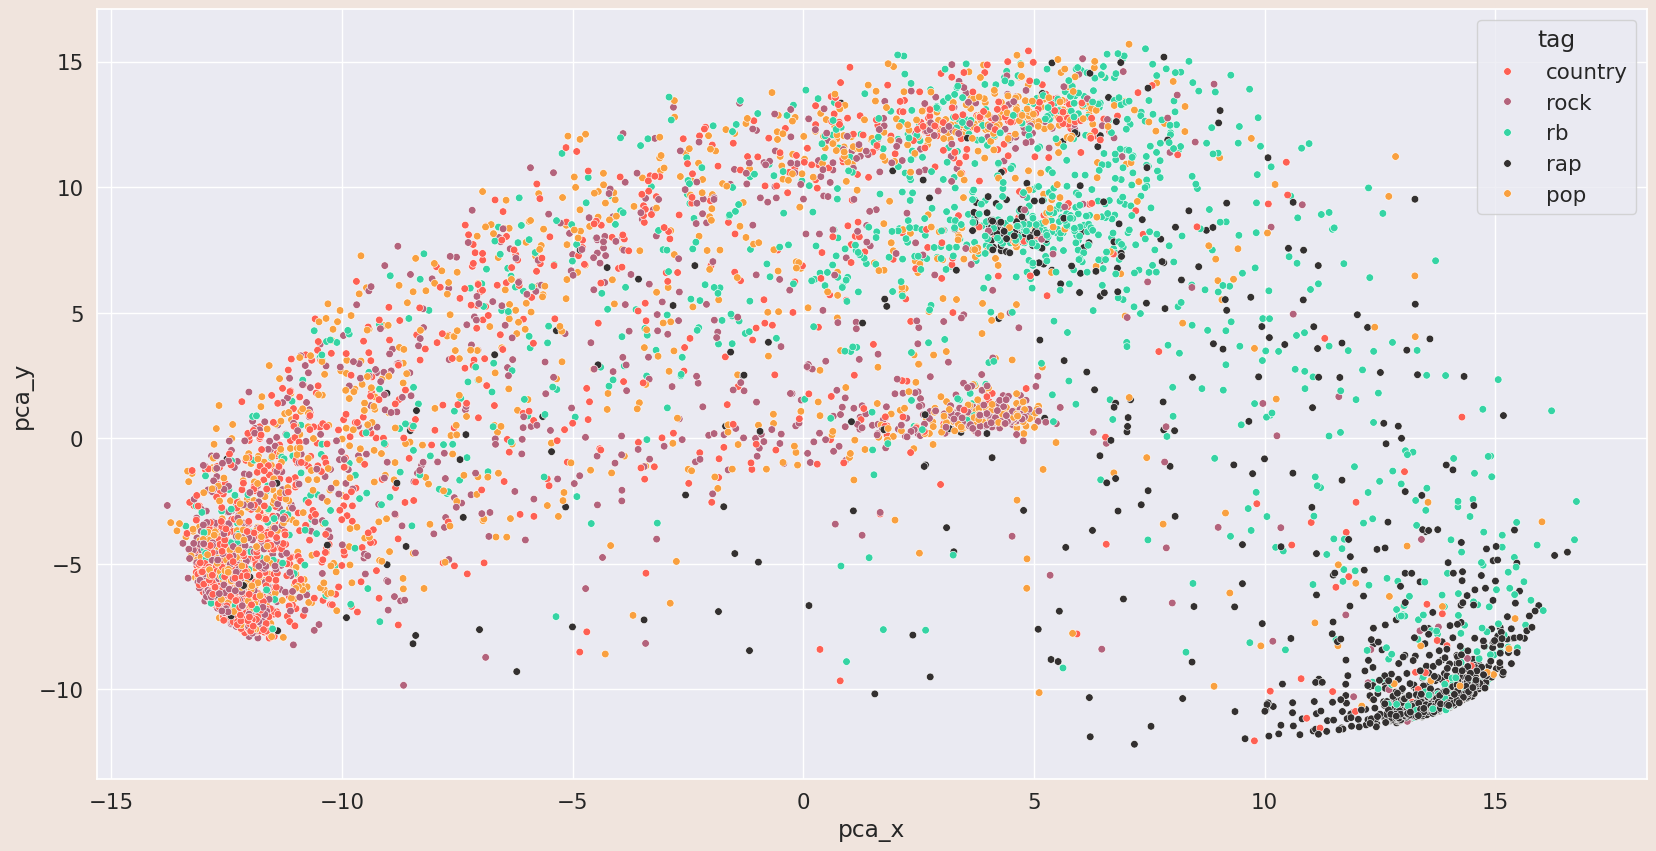

In [15]:
# Plot the data
plt.figure(figsize=(20, 10))
# set background color
plt.gcf().set_facecolor('#f0e4dd')


sns.scatterplot(x='pca_x', y='pca_y', hue='tag', data=df, s=30)
plt.savefig('1st_dataset_pca.png')

# ------------------